# Project Overview
This project aims to build a convolutional neural network that can classify images of coffee beans into one of four categories representing various stages of the roasting process: raw, light, medium, and dark. The model will take jpeg images of coffee beans as an input, analyze the image using convolutional layers, and make a prediction about the roast stage.

This project is important to pursue because it demonstrates how artificial intelligence (AI) can be used to improve processes and outcomes in the coffee industry. By leveraging the power of machine learning, coffee roasters can achieve greater consistency in their roasts, which can lead to higher quality coffee and increased customer satisfaction. Additionally, this project is just the tip of the iceberg when it comes to the potential for innovation in the coffee industry utilizing AI technology. There are many other applications of machine learning in the coffee industry, such as predicting consumer preferences, optimizing supply chain logistics, and improving the efficiency of coffee farming. As such, this project represents an exciting opportunity to explore the possibilities of AI in the coffee industry and beyond.  

The project can be broken down into the following steps:  
- Collect a dataset of labeled images of coffee beans in the four roast level categories.    
- Preprocess the images (resize, crop, normalize, etc.) to make them suitable for training the model.  
- Iterate over various versions of network architecture, hyperparameters and training protocols.   
- Evaluate the performance of each model version on a test dataset to determine accuracy and other key performance indicators (KPI)  
- Deploy the model to a system that can accept jpeg images as input, classify them, and alert workers when the desired roast is achieved. 

# Business Use Case

This project has the potential to significantly improve the coffee roasting process in terms of quality control, labor efficiency, and profitability. By using a camera positioned above the roasting bin to periodically capture images and analyze the roast level of the beans, the system can help coffee roasters achieve greater consistency in their roasts. This can lead to higher quality coffee and increased customer satisfaction.  

In addition, this system can help reduce waste by alerting workers when the beans are overcooked or undercooked, thereby minimizing the amount of coffee that must be discarded. This reduction in waste can have a significant impact on a roaster's bottom line, as it reduces the cost of materials and increases profitability.  

Furthermore, this system can help workers be more productive by allowing them to focus on other tasks while the roasting process is underway. Since the system can monitor the roasting process and alert workers when the desired roast level is achieved, workers do not need to pay as close attention to each roasting bin. This can free up time and resources that can be directed towards other areas of the business, further increasing efficiency and profitability.
Overall, this project represents a powerful tool for coffee roasters looking to improve their operations and achieve greater success in the highly competitive coffee industry. By utilizing AI technology to improve quality control, reduce waste, and increase labor efficiency, coffee roasters can deliver a better product to their customers and increase their bottom line.

# Data Understanding  
The dataset used in this project comes from kaggle.com and consists of 1200 training images and 400 test images. Each sample is equally distributed between the four classes, with 300 images per class in the training set and 100 images per class in the test set. All the images are of a single coffee bean and are of size 224x224 pixels. The dataset's class labels are (Dark, 0), (Green, 1), (Light, 2), and (Medium, 3). The images were captured using an iPhone 12 mini, which means that the images are of high quality and consistent.
To further test the model and the dataset's limitations, I will also create a small validation dataset using our own iPhone 13 pro camera. This dataset will include images of both single coffee beans, like the training and test data, as well as images of multiple beans. By doing so, I hope to evaluate the model's performance in detecting the stage of the roasting process of both individual and multiple beans.
Overall, I believe that this dataset provides a good representation of the different stages of coffee bean roasting, and I am confident that our model can successfully classify coffee bean images.


In [1]:
# dependencies for data preprocessing
import os
from keras.preprocessing.image import ImageDataGenerator

# dependencies for model compilation
from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall
from keras.regularizers import l2

# dependencies for model diagnostics
from sklearn.metrics import confusion_matrix, classification_report
import project_toolkit as ptk

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"

In [3]:

# dictionary of volume of data per class per sample
# len(os.listdir(train_dir+"Dark"))
class_balance_dict = {
    "Train Sample":[len(os.listdir(train_dir+"Dark")),
                    len(os.listdir(train_dir+"Green")),
                    len(os.listdir(train_dir+"Light")),
                    len(os.listdir(train_dir+"Medium"))],
    "Test Sample":[len(os.listdir(test_dir+"Dark")),
                   len(os.listdir(test_dir+"Green")),
                   len(os.listdir(test_dir+"Light")),
                   len(os.listdir(test_dir+"Medium"))]
}

# # class balance dictionary as a dataframe with row index representing class and column index representing sample
class_balance_df = pd.DataFrame(class_balance_dict,index=['Dark','Green','Light','Medium'])
class_balance_df

,Train Sample,Test Sample
Dark,300,100
Green,300,100
Light,300,100
Medium,300,100


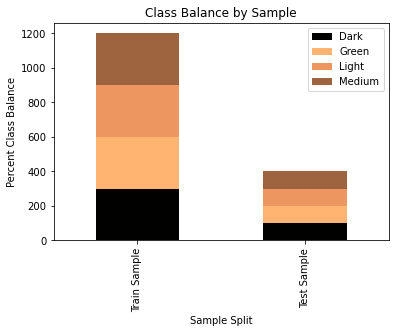

In [4]:
# Create colors
cmap = plt.cm.copper

# create stacked bar chart for students DataFrame
class_balance_df.T.plot(kind='bar', stacked=True, color=[cmap(1), cmap(0.9), cmap(0.75), cmap(0.5)])

# Add Title and Labels
plt.title('Class Balance by Sample')
plt.xlabel('Sample Split')
plt.ylabel('Percent Class Balance')

plt.legend(bbox_to_anchor=(1, 1))

plt.show()

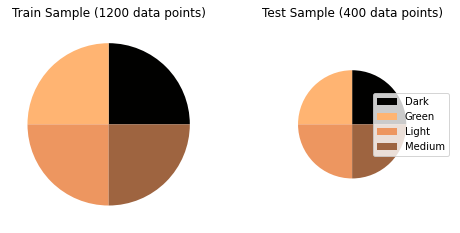

In [5]:
# Define the figure and subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
pie_colors = [cmap(1), cmap(0.9), cmap(0.75), cmap(0.5)]

# Set the radius of the first pie chart
radius1 = 1

# Create the first pie chart
wedges1, texts1 = ax1.pie(class_balance_df['Train Sample'], radius=radius1,colors=pie_colors)

# Set the radius of the second pie chart
radius2 = radius1 * 2 / 3

# Create the second pie chart
wedges2, texts2 = ax2.pie(class_balance_df['Test Sample'], radius=radius2,colors=pie_colors)

# Add a legend to the second pie chart
ax2.legend(wedges2, ['Dark','Green','Light','Medium'], loc="right")

# Set the title for each subplot
ax1.set_title("Train Sample (1200 data points)")
ax2.set_title("Test Sample (400 data points)")

# Show the plot
plt.show()

# Data Preparation

In [6]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# 25 is a common factor or both 1200 and 400
batch_size = 25

In [8]:
train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(224,224),
                       batch_size= batch_size,
                       class_mode='categorical',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(224,224),
                      batch_size= batch_size,
                      class_mode='categorical',
                      color_mode='grayscale')

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


# Modeling Methods

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [10]:
# Building the model
base_model = Sequential()

# 3 convolutional layers
base_model.add(Conv2D(32, (3, 3), input_shape = (224,224,1)))
base_model.add(Activation("relu"))
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Conv2D(64, (3, 3)))
base_model.add(Activation("relu"))
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Conv2D(64, (3, 3)))
base_model.add(Activation("relu"))
base_model.add(MaxPooling2D(pool_size=(2,2)))
base_model.add(Dropout(0.25))

base_model.add(Flatten())
base_model.add(Dense(128))
base_model.add(Activation("relu"))

base_model.add(Dense(128))
base_model.add(Activation("relu"))

base_model.add(Dense(4))
base_model.add(Activation("softmax"))

# Compiling the base_model using some basic parameters
base_model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [11]:
base_model_results = base_model.fit(
                     train_data_generator,
                     batch_size=batch_size,
                     epochs=1,
                     steps_per_epoch=48,
                     validation_data=test_data_generator,
                     validation_batch_size=batch_size,
                     validation_steps=16
                     )

48/48 [==============================] - 80s 2s/step - loss: 1.0946 - accuracy: 0.4467 - val_loss: 0.6595 - val_accuracy: 0.7400


In [12]:
base_acc, base_loss, base_report, base_matrix, base_labels = ptk.evaluate_model(base_model,test_data_generator)

13/13 [==============================] - 5s 392ms/step - loss: 0.6595 - accuracy: 0.7400
Done!


c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print(base_report)

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       100
           1       0.73      0.94      0.82       100
           2       0.83      0.44      0.58       100
           3       0.91      0.20      0.33       100

   micro avg       0.76      0.62      0.68       400
   macro avg       0.80      0.62      0.63       400
weighted avg       0.80      0.62      0.63       400
 samples avg       0.62      0.62      0.62       400



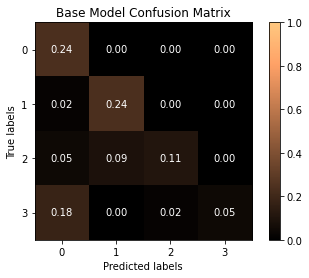

In [14]:
ptk.viz_confusion_matrix(base_matrix,'Base Model Confusion Matrix')

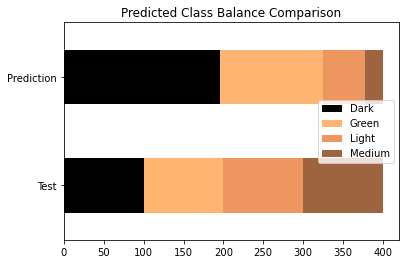

In [15]:
base_class_balance_df = ptk.viz_class_balance_comparison(base_labels[0],base_labels[1])

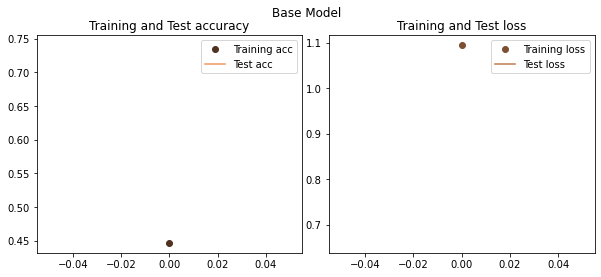

In [16]:
ptk.viz_training_history(base_model_results,'Base Model')